# ML Model to Predict the Clear Date of the Costumer

#### Ansukun Gouda   H2HBABBA1533


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### Loading Datasets

In [2]:
#data set is loaded which is in csv format
data = pd.read_csv('H2HBABBA1533.csv')

In [3]:
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200895843,US,2019-09-09 00:00:00,2019.0,1.929776e+09,2019-08-22,20190822,20190822,20190906.0,USD,RV,1.0,NaN,41386.61,20190822.0,NAA8,1.929776e+09,0
1,U001,0200769623,WAL-MAR,2019-11-25 00:00:00,2019.0,1.930144e+09,2019-11-12,20191112,20191112,20191127.0,USD,RV,1.0,NaN,47178.82,20191112.0,NAH4,1.930144e+09,0
2,U001,0200769623,WAL-MAR foundation,2019-04-23 00:00:00,2019.0,1.929131e+09,2019-04-12,20190411,20190412,20190427.0,USD,RV,1.0,NaN,51389.52,20190412.0,NAH4,1.929131e+09,0
3,U001,0200769623,WAL-MAR co,2019-11-26 00:00:00,2019.0,1.930124e+09,2019-11-15,20191107,20191115,20191130.0,USD,RV,1.0,NaN,18177.18,20191115.0,NAH4,1.930124e+09,0
4,U001,0200769623,WAL-MAR,NaN,2020.0,1.930737e+09,2020-04-03,20200403,20200403,20200418.0,USD,RV,1.0,NaN,24079.57,20200403.0,NAH4,1.930737e+09,1


In [4]:
#before preprocessign we need to train part so that we can predict and put in that datasets
Temp2 = data.loc[data.clear_date.isnull()]

In [5]:
data.shape

(50000, 19)

# Data Preprocessing

In [6]:
#check for null values
data.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    4
isOpen                        0
dtype: int64

In [7]:
#since  area_business all  the values are null so drop it
data.drop('area_business',axis = 1,inplace =True)

In [8]:
#check for the conntant features
data.columns[data.nunique()<=1]

Index(['posting_id'], dtype='object')

In [9]:
#drop posting_id as it is a constant features
data.drop('posting_id',axis = 1,inplace =True)

In [10]:
data['doc_id'].value_counts()

1.929807e+09    3
1.928856e+09    3
1.929868e+09    3
1.929196e+09    3
1.930828e+09    3
               ..
1.930549e+09    1
1.930214e+09    1
1.928826e+09    1
1.929491e+09    1
1.928814e+09    1
Name: doc_id, Length: 48788, dtype: int64

In [11]:
#since it is also getting almost constant do we can drop it 
data.drop('doc_id',axis = 1,inplace =True)

In [12]:
#since it is also getting almost unique do we can drop it  as we dont't need ids for training models
data.drop('invoice_id',axis = 1,inplace =True)

In [13]:
#creating a temp dataset to check for qausi-constants
# a new list in created discarding the object datatype feature columns
temp_data = data.drop(labels=['cust_number','business_code','name_customer','clear_date','posting_date','invoice_currency','document type','cust_payment_terms'], axis=1)
temp_data.dtypes

buisness_year             float64
document_create_date        int64
document_create_date.1      int64
due_in_date               float64
total_open_amount         float64
baseline_create_date      float64
isOpen                      int64
dtype: object

In [14]:
#checking for quasi-constant 
s = VarianceThreshold(
    threshold=0.01)

s.fit(temp_data)
sum(s.get_support())

7

In [15]:
#  print the quasi-constant features if Any 
print(
    len([
        x for x in temp_data.columns
        if x not in temp_data.columns[s.get_support()]
    ]))

[x for x in temp_data.columns if x not in temp_data.columns[s.get_support()]]

0


[]

In [16]:
#check for the duplicates doing transpose
data_trans = data.T

In [17]:
data_trans.duplicated().sum()

0

<AxesSubplot:>

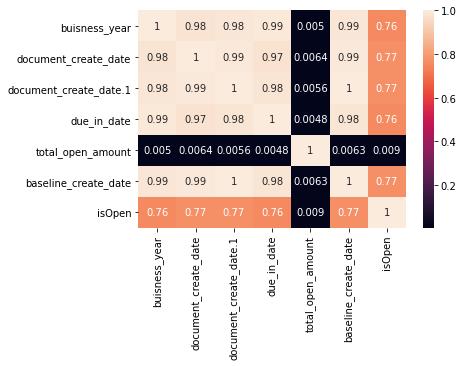

In [18]:
cor = data.corr()
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, annot=True)

In [19]:
data.dtypes

business_code              object
cust_number                object
name_customer              object
clear_date                 object
buisness_year             float64
posting_date               object
document_create_date        int64
document_create_date.1      int64
due_in_date               float64
invoice_currency           object
document type              object
total_open_amount         float64
baseline_create_date      float64
cust_payment_terms         object
isOpen                      int64
dtype: object

In [20]:
data[data['invoice_currency'] == 'CAD'].head()

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
25,CA02,0140104409,LOB trust,NaN,2020.0,2020-02-29,20200229,20200229,20200314.0,CAD,RV,150136.21,20200304.0,CA10,1
36,CA02,0140104429,COSTCO co,2019-07-02 00:00:00,2019.0,2019-06-05,20190605,20190605,20190624.0,CAD,RV,15993.34,20190614.0,CA10,0
37,CA02,0140106408,WAL-M foundation,NaN,2020.0,2020-03-21,20200321,20200321,20200331.0,CAD,RV,4878.02,20200321.0,CA10,1
43,CA02,0140104423,METRO llc,NaN,2020.0,2020-04-20,20200420,20200420,20200501.0,CAD,RV,162295.09,20200421.0,CA10,1
60,CA02,0140104429,COSTCO systems,NaN,2020.0,2020-02-27,20200227,20200227,20200309.0,CAD,RV,12383.81,20200228.0,CA10,1


In [21]:
#All the amounts which are in CAD currency are converted into USD currency format
data['total_open_amount'] = np.where((data['invoice_currency'] == 'CAD') ,((data['total_open_amount'])*0.81),(data['total_open_amount']))

In [22]:
# All the CAD is converted to USD
data['invoice_currency'] = 'USD'
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
0,U001,0200895843,US,2019-09-09 00:00:00,2019.0,2019-08-22,20190822,20190822,20190906.0,USD,RV,41386.61,20190822.0,NAA8,0
1,U001,0200769623,WAL-MAR,2019-11-25 00:00:00,2019.0,2019-11-12,20191112,20191112,20191127.0,USD,RV,47178.82,20191112.0,NAH4,0
2,U001,0200769623,WAL-MAR foundation,2019-04-23 00:00:00,2019.0,2019-04-12,20190411,20190412,20190427.0,USD,RV,51389.52,20190412.0,NAH4,0
3,U001,0200769623,WAL-MAR co,2019-11-26 00:00:00,2019.0,2019-11-15,20191107,20191115,20191130.0,USD,RV,18177.18,20191115.0,NAH4,0
4,U001,0200769623,WAL-MAR,NaN,2020.0,2020-04-03,20200403,20200403,20200418.0,USD,RV,24079.57,20200403.0,NAH4,1


In [23]:
data['invoice_currency'].unique()

array(['USD'], dtype=object)

In [24]:
#since the invoice_currency becomes a constant so it is of no use thus dropped
data.drop(columns=['invoice_currency'],inplace=True)

In [25]:
#date feature columns are converted into datetime format for future operation
data['clear_date'] = pd.to_datetime(data['clear_date'])
data['buisness_year']=data['buisness_year'].astype('int')
data['posting_date'] = pd.to_datetime(data['posting_date']) 
data['document_create_date.1'] = pd.to_datetime(data['document_create_date.1'], format='%Y%m%d')
data['due_in_date'] = pd.to_datetime(data['due_in_date'], format='%Y%m%d')
data['baseline_create_date'] = pd.to_datetime(data['due_in_date'], format='%Y%m%d')

data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
0,U001,0200895843,US,2019-09-09,2019,2019-08-22,20190822,2019-08-22,2019-09-06,RV,41386.61,2019-09-06,NAA8,0
1,U001,0200769623,WAL-MAR,2019-11-25,2019,2019-11-12,20191112,2019-11-12,2019-11-27,RV,47178.82,2019-11-27,NAH4,0
2,U001,0200769623,WAL-MAR foundation,2019-04-23,2019,2019-04-12,20190411,2019-04-12,2019-04-27,RV,51389.52,2019-04-27,NAH4,0
3,U001,0200769623,WAL-MAR co,2019-11-26,2019,2019-11-15,20191107,2019-11-15,2019-11-30,RV,18177.18,2019-11-30,NAH4,0
4,U001,0200769623,WAL-MAR,NaT,2020,2020-04-03,20200403,2020-04-03,2020-04-18,RV,24079.57,2020-04-18,NAH4,1


In [26]:
#sort the train data according to posting_date as we can't train model based on future data
data.sort_values(['posting_date'],inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
0,U001,0200726979,BJ'S foundation,2019-01-15,2019,2018-12-30,20181229,2018-12-30,2019-01-14,RV,42.04,2019-01-14,NAA8,0
1,U001,0200726979,BJ'S corporation,2019-01-15,2019,2018-12-30,20181229,2018-12-30,2019-01-14,RV,53.25,2019-01-14,NAA8,0
2,U001,0200769623,WAL-MAR us,2019-01-15,2019,2018-12-30,20181229,2018-12-30,2019-01-14,RV,344.01,2019-01-14,NAH4,0
3,U001,0200744019,TARG trust,2019-01-18,2019,2018-12-30,20181229,2018-12-30,2019-01-14,RV,11982.59,2019-01-14,NAA8,0
4,U001,0200769623,WAL-MAR co,2019-01-15,2019,2018-12-30,20181229,2018-12-30,2019-01-14,RV,65940.47,2019-01-14,NAH4,0


In [27]:
# since we are using the normalized form document_create_date.1 so we can drop the other one document_create_date 
# as it is highly corelated  as stated in heatmap 
data.drop('document_create_date',axis=1,inplace=True)

In [28]:
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,posting_date,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
0,U001,0200726979,BJ'S foundation,2019-01-15,2019,2018-12-30,2018-12-30,2019-01-14,RV,42.04,2019-01-14,NAA8,0
1,U001,0200726979,BJ'S corporation,2019-01-15,2019,2018-12-30,2018-12-30,2019-01-14,RV,53.25,2019-01-14,NAA8,0
2,U001,0200769623,WAL-MAR us,2019-01-15,2019,2018-12-30,2018-12-30,2019-01-14,RV,344.01,2019-01-14,NAH4,0
3,U001,0200744019,TARG trust,2019-01-18,2019,2018-12-30,2018-12-30,2019-01-14,RV,11982.59,2019-01-14,NAA8,0
4,U001,0200769623,WAL-MAR co,2019-01-15,2019,2018-12-30,2018-12-30,2019-01-14,RV,65940.47,2019-01-14,NAH4,0


In [29]:
data.corr()

,buisness_year,total_open_amount,isOpen
buisness_year,1.000000,0.006567,0.757732
total_open_amount,0.006567,1.000000,0.010158
isOpen,0.757732,0.010158,1.000000


In [30]:
#we also don't need positng date so we can drop it too
data.drop(columns = 'posting_date' , inplace = True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   business_code           50000 non-null  object        
 1   cust_number             50000 non-null  object        
 2   name_customer           50000 non-null  object        
 3   clear_date              40000 non-null  datetime64[ns]
 4   buisness_year           50000 non-null  int32         
 5   document_create_date.1  50000 non-null  datetime64[ns]
 6   due_in_date             50000 non-null  datetime64[ns]
 7   document type           50000 non-null  object        
 8   total_open_amount       50000 non-null  float64       
 9   baseline_create_date    50000 non-null  datetime64[ns]
 10  cust_payment_terms      50000 non-null  object        
 11  isOpen                  50000 non-null  int64         
dtypes: datetime64[ns](4), float64(1), int32(1), in

# Splitting of data based on null values present in clear_dates

In [32]:
#splitting the the test and train data based on the clear_data features
#A new data set is created based on 
Train = data.loc[data['clear_date'].notnull()]
Train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
0,U001,0200726979,BJ'S foundation,2019-01-15,2019,2018-12-30,2019-01-14,RV,42.04,2019-01-14,NAA8,0
1,U001,0200726979,BJ'S corporation,2019-01-15,2019,2018-12-30,2019-01-14,RV,53.25,2019-01-14,NAA8,0
2,U001,0200769623,WAL-MAR us,2019-01-15,2019,2018-12-30,2019-01-14,RV,344.01,2019-01-14,NAH4,0
3,U001,0200744019,TARG trust,2019-01-18,2019,2018-12-30,2019-01-14,RV,11982.59,2019-01-14,NAA8,0
4,U001,0200769623,WAL-MAR co,2019-01-15,2019,2018-12-30,2019-01-14,RV,65940.47,2019-01-14,NAH4,0


In [33]:
#Where clear_date == null is putted into test dataframe
Test = data.loc[data.clear_date.isnull()]
Test.shape

(10000, 12)

In [34]:
#temp datset is created to put the clear_dates predicted at last into this dataset after predictions
data_temp = Test

In [35]:
#calculating  the delay feature using clear_date-due_date
Train['DELAY']=Train['clear_date'] - Train['due_in_date']
Train['DELAY'] =Train['DELAY'].dt.days
Train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen,DELAY
0,U001,0200726979,BJ'S foundation,2019-01-15,2019,2018-12-30,2019-01-14,RV,42.04,2019-01-14,NAA8,0,1
1,U001,0200726979,BJ'S corporation,2019-01-15,2019,2018-12-30,2019-01-14,RV,53.25,2019-01-14,NAA8,0,1
2,U001,0200769623,WAL-MAR us,2019-01-15,2019,2018-12-30,2019-01-14,RV,344.01,2019-01-14,NAH4,0,1
3,U001,0200744019,TARG trust,2019-01-18,2019,2018-12-30,2019-01-14,RV,11982.59,2019-01-14,NAA8,0,4
4,U001,0200769623,WAL-MAR co,2019-01-15,2019,2018-12-30,2019-01-14,RV,65940.47,2019-01-14,NAH4,0,1


# Check For Anomalies if Present 

In [36]:
# #check for  data where clear_date can be before the document_create_date.1
v1=Train[Train['clear_date']<Train['document_create_date.1']].index

In [37]:
v1 

Int64Index([], dtype='int64')

In [38]:
# #check for  data where due_in_date can be before the document_create_date.1
v2=Train[Train['due_in_date']<Train['document_create_date.1']].index

In [39]:
v2 

Int64Index([  828,   896,  2360,  2369,  2456,  2457,  2461,  2464,  2467,
             2489,
            ...
            35702, 35741, 36263, 37161, 37169, 38522, 38608, 38635, 39680,
            39875],
           dtype='int64', length=105)

In [40]:
v3=Train[Train['clear_date']<Train['baseline_create_date']].index #Anomalies found with clear_date before baseline_date that needs to b

In [41]:
v3

Int64Index([    5,     7,    12,    14,    16,    17,    19,    27,    33,
               35,
            ...
            39975, 39976, 39979, 39981, 39984, 39985, 39986, 40018, 40033,
            40116],
           dtype='int64', length=14701)

In [42]:
#deleting the rows having anomalies
Train.drop(v2,inplace=True)

In [43]:
#deleting the rows having anomalies
Train.drop(v3,inplace=True)

In [44]:
#after checking for anomalies we dropped the baselin_date as it is highly corelated with doucment_create_date and other features
Train.drop('baseline_create_date',axis= 1,inplace =True)

In [45]:
Train.nunique()

business_code                 6
cust_number                1086
name_customer              3053
clear_date                  378
buisness_year                 2
document_create_date.1      421
due_in_date                 480
document type                 2
total_open_amount         23082
cust_payment_terms           65
isOpen                        1
DELAY                       120
dtype: int64

In [46]:
#Since  isOpen has only one unique value  so we dropped it
Train.drop(['isOpen'],axis = 1 ,inplace =True)

In [47]:
# month_quarter,month are calculated for due date and document create date for further use in model prediction
Train['document_create_date.1_month_quarter'] = Train['document_create_date.1'].dt.quarter
Train['document_create_date.1_day'] = Train['document_create_date.1'].dt.dayofweek
Train['document_create_date.1_month'] = Train['document_create_date.1'].dt.month
Train['due_in_date_month_quarter'] =Train['due_in_date'].dt.quarter
Train['due_in_date_month_day'] =Train['due_in_date'].dt.dayofweek
Train['due_in_date_month'] =Train['due_in_date'].dt.month

In [48]:
Train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,document type,total_open_amount,cust_payment_terms,DELAY,document_create_date.1_month_quarter,document_create_date.1_day,document_create_date.1_month,due_in_date_month_quarter,due_in_date_month_day,due_in_date_month
0,U001,0200726979,BJ'S foundation,2019-01-15,2019,2018-12-30,2019-01-14,RV,42.04,NAA8,1,4,6,12,1,0,1
1,U001,0200726979,BJ'S corporation,2019-01-15,2019,2018-12-30,2019-01-14,RV,53.25,NAA8,1,4,6,12,1,0,1
2,U001,0200769623,WAL-MAR us,2019-01-15,2019,2018-12-30,2019-01-14,RV,344.01,NAH4,1,4,6,12,1,0,1
3,U001,0200744019,TARG trust,2019-01-18,2019,2018-12-30,2019-01-14,RV,11982.59,NAA8,4,4,6,12,1,0,1
4,U001,0200769623,WAL-MAR co,2019-01-15,2019,2018-12-30,2019-01-14,RV,65940.47,NAH4,1,4,6,12,1,0,1


# EDA

6.267301730177616


<AxesSubplot:xlabel='DELAY', ylabel='Density'>

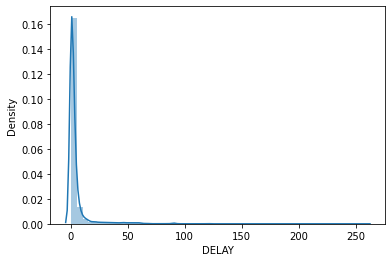

In [49]:
print(Train['DELAY'].skew())
sns.distplot(Train['DELAY']) 

1.999995783111647


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

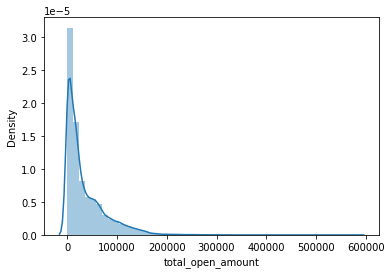

In [50]:
print(Train['total_open_amount'].skew())
sns.distplot(Train['total_open_amount']) 

-1.0034646769163373


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

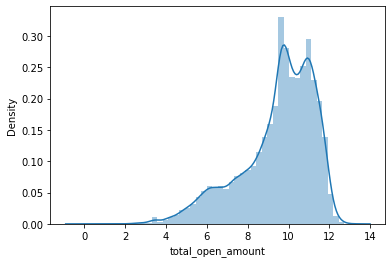

In [51]:
x_log = np.log(Train['total_open_amount'])
print(x_log.skew())
sns.distplot(np.log(Train['total_open_amount']))


-0.12043085295489626


<AxesSubplot:ylabel='Density'>

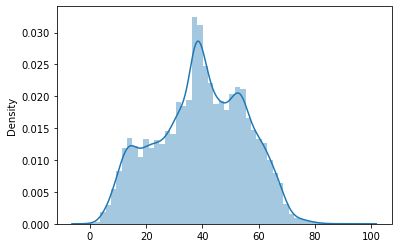

In [52]:
from scipy import stats
x2 = stats.boxcox(Train['total_open_amount'])[0]
x3 = pd.Series(x2)
print(x3.skew())
sns.distplot(x2) 

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

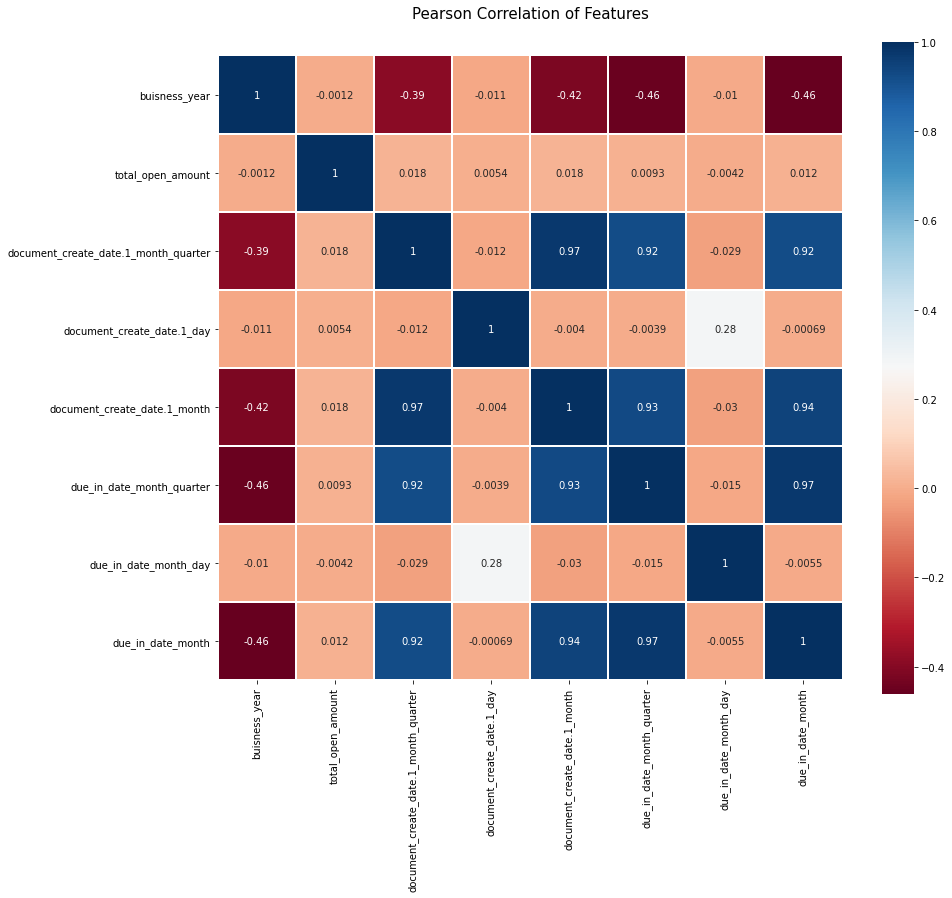

In [53]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Train.drop('DELAY',axis =1).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

<AxesSubplot:xlabel='total_open_amount', ylabel='DELAY'>

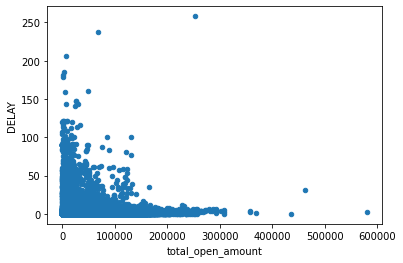

In [54]:
Train.plot(x="total_open_amount", y="DELAY", kind="scatter")

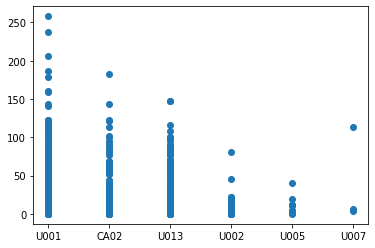

In [55]:
plt.plot_date(Train['business_code'], Train['DELAY'], )
plt.show()

#### This Graph states that one having business code as U001 makes the highest delay in paying the dues

# Feature Engineering

In [56]:
#clear_date,document_create_date.1,due_in_date are dropped because they are catagorical date  column and can not be passed into model for training
Train.drop(columns=['clear_date','document_create_date.1','due_in_date'],inplace=True)

In [57]:
Train.head()

,business_code,cust_number,name_customer,buisness_year,document type,total_open_amount,cust_payment_terms,DELAY,document_create_date.1_month_quarter,document_create_date.1_day,document_create_date.1_month,due_in_date_month_quarter,due_in_date_month_day,due_in_date_month
0,U001,0200726979,BJ'S foundation,2019,RV,42.04,NAA8,1,4,6,12,1,0,1
1,U001,0200726979,BJ'S corporation,2019,RV,53.25,NAA8,1,4,6,12,1,0,1
2,U001,0200769623,WAL-MAR us,2019,RV,344.01,NAH4,1,4,6,12,1,0,1
3,U001,0200744019,TARG trust,2019,RV,11982.59,NAA8,4,4,6,12,1,0,1
4,U001,0200769623,WAL-MAR co,2019,RV,65940.47,NAH4,1,4,6,12,1,0,1


In [58]:
#since some features are catagorical  we have done label-encoding so that we can pass to model 
labelencoder = LabelEncoder()
Train.iloc[:,0] = labelencoder.fit_transform(Train.iloc[:,0])
Train.iloc[:,1] = labelencoder.fit_transform(Train.iloc[:,1])
Train.iloc[:,3] = labelencoder.fit_transform(Train.iloc[:,3])
Train.iloc[:,4] = labelencoder.fit_transform(Train.iloc[:,4])
Train.iloc[:,6] = labelencoder.fit_transform(Train.iloc[:,6])

In [59]:
Train.head()

,business_code,cust_number,name_customer,buisness_year,document type,total_open_amount,cust_payment_terms,DELAY,document_create_date.1_month_quarter,document_create_date.1_day,document_create_date.1_month,due_in_date_month_quarter,due_in_date_month_day,due_in_date_month
0,1,601,BJ'S foundation,0,0,42.04,20,1,4,6,12,1,0,1
1,1,601,BJ'S corporation,0,0,53.25,20,1,4,6,12,1,0,1
2,1,687,WAL-MAR us,0,0,344.01,33,1,4,6,12,1,0,1
3,1,640,TARG trust,0,0,11982.59,20,4,4,6,12,1,0,1
4,1,687,WAL-MAR co,0,0,65940.47,33,1,4,6,12,1,0,1


In [60]:
## We can drop customer name as it is depicted by customer number
Train.drop('name_customer',inplace=True,axis=1)

In [61]:
Train.head()

,business_code,cust_number,buisness_year,document type,total_open_amount,cust_payment_terms,DELAY,document_create_date.1_month_quarter,document_create_date.1_day,document_create_date.1_month,due_in_date_month_quarter,due_in_date_month_day,due_in_date_month
0,1,601,0,0,42.04,20,1,4,6,12,1,0,1
1,1,601,0,0,53.25,20,1,4,6,12,1,0,1
2,1,687,0,0,344.01,33,1,4,6,12,1,0,1
3,1,640,0,0,11982.59,20,4,4,6,12,1,0,1
4,1,687,0,0,65940.47,33,1,4,6,12,1,0,1


In [62]:
Train.head()

,business_code,cust_number,buisness_year,document type,total_open_amount,cust_payment_terms,DELAY,document_create_date.1_month_quarter,document_create_date.1_day,document_create_date.1_month,due_in_date_month_quarter,due_in_date_month_day,due_in_date_month
0,1,601,0,0,42.04,20,1,4,6,12,1,0,1
1,1,601,0,0,53.25,20,1,4,6,12,1,0,1
2,1,687,0,0,344.01,33,1,4,6,12,1,0,1
3,1,640,0,0,11982.59,20,4,4,6,12,1,0,1
4,1,687,0,0,65940.47,33,1,4,6,12,1,0,1


In [63]:
Train.head()

,business_code,cust_number,buisness_year,document type,total_open_amount,cust_payment_terms,DELAY,document_create_date.1_month_quarter,document_create_date.1_day,document_create_date.1_month,due_in_date_month_quarter,due_in_date_month_day,due_in_date_month
0,1,601,0,0,42.04,20,1,4,6,12,1,0,1
1,1,601,0,0,53.25,20,1,4,6,12,1,0,1
2,1,687,0,0,344.01,33,1,4,6,12,1,0,1
3,1,640,0,0,11982.59,20,4,4,6,12,1,0,1
4,1,687,0,0,65940.47,33,1,4,6,12,1,0,1


In [64]:
Train.dtypes

business_code                             int32
cust_number                               int32
buisness_year                             int64
document type                             int32
total_open_amount                       float64
cust_payment_terms                        int32
DELAY                                     int64
document_create_date.1_month_quarter      int64
document_create_date.1_day                int64
document_create_date.1_month              int64
due_in_date_month_quarter                 int64
due_in_date_month_day                     int64
due_in_date_month                         int64
dtype: object

In [65]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25194 entries, 0 to 40097
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   business_code                         25194 non-null  int32  
 1   cust_number                           25194 non-null  int32  
 2   buisness_year                         25194 non-null  int64  
 3   document type                         25194 non-null  int32  
 4   total_open_amount                     25194 non-null  float64
 5   cust_payment_terms                    25194 non-null  int32  
 6   DELAY                                 25194 non-null  int64  
 7   document_create_date.1_month_quarter  25194 non-null  int64  
 8   document_create_date.1_day            25194 non-null  int64  
 9   document_create_date.1_month          25194 non-null  int64  
 10  due_in_date_month_quarter             25194 non-null  int64  
 11  due_in_date_mon

In [66]:
Train.dtypes

business_code                             int32
cust_number                               int32
buisness_year                             int64
document type                             int32
total_open_amount                       float64
cust_payment_terms                        int32
DELAY                                     int64
document_create_date.1_month_quarter      int64
document_create_date.1_day                int64
document_create_date.1_month              int64
due_in_date_month_quarter                 int64
due_in_date_month_day                     int64
due_in_date_month                         int64
dtype: object

# Mapping the features in Main test set for predictions

In [67]:
Test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
39994,U001,0200769623,WAL-MAR foundation,NaT,2020,2020-02-27,2020-03-13,RV,471.56,2020-03-13,NAH4,1
39995,U001,0200418007,AM llc,NaT,2020,2020-02-27,2020-03-13,RV,1215.32,2020-03-13,NAA8,1
39996,U001,0200782001,GORDO,NaT,2020,2020-02-27,2020-03-13,RV,37980.09,2020-03-13,NAA8,1
39997,U001,0200799367,MCL systems,NaT,2020,2020-02-27,2020-03-13,RV,8690.06,2020-03-13,NAA8,1
39998,U001,0200290370,BARGAIN llc,NaT,2020,2020-02-27,2020-03-13,RV,16865.11,2020-03-13,NAA8,1


In [68]:
Test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
39994,U001,0200769623,WAL-MAR foundation,NaT,2020,2020-02-27,2020-03-13,RV,471.56,2020-03-13,NAH4,1
39995,U001,0200418007,AM llc,NaT,2020,2020-02-27,2020-03-13,RV,1215.32,2020-03-13,NAA8,1
39996,U001,0200782001,GORDO,NaT,2020,2020-02-27,2020-03-13,RV,37980.09,2020-03-13,NAA8,1
39997,U001,0200799367,MCL systems,NaT,2020,2020-02-27,2020-03-13,RV,8690.06,2020-03-13,NAA8,1
39998,U001,0200290370,BARGAIN llc,NaT,2020,2020-02-27,2020-03-13,RV,16865.11,2020-03-13,NAA8,1


In [69]:
#dropping the features 
Test.drop(['name_customer','isOpen'],axis =1,inplace =True)

In [70]:
Test.dtypes

business_code                     object
cust_number                       object
clear_date                datetime64[ns]
buisness_year                      int32
document_create_date.1    datetime64[ns]
due_in_date               datetime64[ns]
document type                     object
total_open_amount                float64
baseline_create_date      datetime64[ns]
cust_payment_terms                object
dtype: object

In [71]:
#segregating the date columns into day , months and year 
Test['document_create_date.1_month_quarter'] = Test['document_create_date.1'].dt.quarter
Test['document_create_date.1_day'] = Test['document_create_date.1'].dt.dayofweek
Test['document_create_date.1_month'] = Test['document_create_date.1'].dt.month
Test['due_in_date_month_quarter'] =Test['due_in_date'].dt.quarter
Test['due_in_date_month_day'] =Test['due_in_date'].dt.dayofweek
Test['due_in_date_month'] =Test['due_in_date'].dt.month

In [72]:
Test.dtypes

business_code                                   object
cust_number                                     object
clear_date                              datetime64[ns]
buisness_year                                    int32
document_create_date.1                  datetime64[ns]
due_in_date                             datetime64[ns]
document type                                   object
total_open_amount                              float64
baseline_create_date                    datetime64[ns]
cust_payment_terms                              object
document_create_date.1_month_quarter             int64
document_create_date.1_day                       int64
document_create_date.1_month                     int64
due_in_date_month_quarter                        int64
due_in_date_month_day                            int64
due_in_date_month                                int64
dtype: object

In [73]:
#clear_date,document_create_date.1,due_in_date are dropped because they are  date column and can not be passed into model for training
Test.drop(columns=['clear_date','document_create_date.1','due_in_date'],axis =1,inplace=True)

In [74]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 39994 to 49999
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   business_code                         10000 non-null  object        
 1   cust_number                           10000 non-null  object        
 2   buisness_year                         10000 non-null  int32         
 3   document type                         10000 non-null  object        
 4   total_open_amount                     10000 non-null  float64       
 5   baseline_create_date                  10000 non-null  datetime64[ns]
 6   cust_payment_terms                    10000 non-null  object        
 7   document_create_date.1_month_quarter  10000 non-null  int64         
 8   document_create_date.1_day            10000 non-null  int64         
 9   document_create_date.1_month          10000 non-null  int64         

In [75]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 39994 to 49999
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   business_code                         10000 non-null  object        
 1   cust_number                           10000 non-null  object        
 2   buisness_year                         10000 non-null  int32         
 3   document type                         10000 non-null  object        
 4   total_open_amount                     10000 non-null  float64       
 5   baseline_create_date                  10000 non-null  datetime64[ns]
 6   cust_payment_terms                    10000 non-null  object        
 7   document_create_date.1_month_quarter  10000 non-null  int64         
 8   document_create_date.1_day            10000 non-null  int64         
 9   document_create_date.1_month          10000 non-null  int64         

In [76]:
Test.head()

,business_code,cust_number,buisness_year,document type,total_open_amount,baseline_create_date,cust_payment_terms,document_create_date.1_month_quarter,document_create_date.1_day,document_create_date.1_month,due_in_date_month_quarter,due_in_date_month_day,due_in_date_month
39994,U001,0200769623,2020,RV,471.56,2020-03-13,NAH4,1,3,2,1,4,3
39995,U001,0200418007,2020,RV,1215.32,2020-03-13,NAA8,1,3,2,1,4,3
39996,U001,0200782001,2020,RV,37980.09,2020-03-13,NAA8,1,3,2,1,4,3
39997,U001,0200799367,2020,RV,8690.06,2020-03-13,NAA8,1,3,2,1,4,3
39998,U001,0200290370,2020,RV,16865.11,2020-03-13,NAA8,1,3,2,1,4,3


In [77]:
#Label encoding the object fetures
labelencoder = LabelEncoder()
Test.iloc[:,0] = labelencoder.fit_transform(Test.iloc[:,0])
Test.iloc[:,1] = labelencoder.fit_transform(Test.iloc[:,1])
Test.iloc[:,3] = labelencoder.fit_transform(Test.iloc[:,3])
Test.iloc[:,6] = labelencoder.fit_transform(Test.iloc[:,6])

In [78]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 39994 to 49999
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   business_code                         10000 non-null  int32         
 1   cust_number                           10000 non-null  int32         
 2   buisness_year                         10000 non-null  int32         
 3   document type                         10000 non-null  int32         
 4   total_open_amount                     10000 non-null  float64       
 5   baseline_create_date                  10000 non-null  datetime64[ns]
 6   cust_payment_terms                    10000 non-null  int32         
 7   document_create_date.1_month_quarter  10000 non-null  int64         
 8   document_create_date.1_day            10000 non-null  int64         
 9   document_create_date.1_month          10000 non-null  int64         

In [79]:
Test.isnull().sum()

business_code                           0
cust_number                             0
buisness_year                           0
document type                           0
total_open_amount                       0
baseline_create_date                    0
cust_payment_terms                      0
document_create_date.1_month_quarter    0
document_create_date.1_day              0
document_create_date.1_month            0
due_in_date_month_quarter               0
due_in_date_month_day                   0
due_in_date_month                       0
dtype: int64

In [80]:
Test.drop('baseline_create_date',axis =1,inplace =True)

In [81]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 39994 to 49999
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   business_code                         10000 non-null  int32  
 1   cust_number                           10000 non-null  int32  
 2   buisness_year                         10000 non-null  int32  
 3   document type                         10000 non-null  int32  
 4   total_open_amount                     10000 non-null  float64
 5   cust_payment_terms                    10000 non-null  int32  
 6   document_create_date.1_month_quarter  10000 non-null  int64  
 7   document_create_date.1_day            10000 non-null  int64  
 8   document_create_date.1_month          10000 non-null  int64  
 9   due_in_date_month_quarter             10000 non-null  int64  
 10  due_in_date_month_day                 10000 non-null  int64  
 11  due_in_date

In [82]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 39994 to 49999
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   business_code                         10000 non-null  int32  
 1   cust_number                           10000 non-null  int32  
 2   buisness_year                         10000 non-null  int32  
 3   document type                         10000 non-null  int32  
 4   total_open_amount                     10000 non-null  float64
 5   cust_payment_terms                    10000 non-null  int32  
 6   document_create_date.1_month_quarter  10000 non-null  int64  
 7   document_create_date.1_day            10000 non-null  int64  
 8   document_create_date.1_month          10000 non-null  int64  
 9   due_in_date_month_quarter             10000 non-null  int64  
 10  due_in_date_month_day                 10000 non-null  int64  
 11  due_in_date

#### Now the Test set is also ready to feed  the model for predictions

#  Outliers Handling Through IQR Treatment

In [83]:
#to handle the outliers present in total open amount we are doing the IQR treatment
upper_limit=Train['total_open_amount'].quantile(0.99) 
print(upper_limit)

164898.9778999999


In [84]:
Train.loc[(Train['total_open_amount']>upper_limit),'total_open_amount']=upper_limit

# Splitting the dataset into x and y dataset to feed the model

In [85]:
X_train, valid = train_test_split(Train,test_size=.2,shuffle=False)
X_train.shape,valid.shape

((20155, 13), (5039, 13))

In [86]:
valid_set,test_set = train_test_split(valid,test_size=.5,shuffle=False)
test_set.shape,valid_set.shape

((2520, 13), (2519, 13))

In [87]:
# splitting datsets into train set , valid sets and test sets
X=X_train.drop('DELAY',axis=1)
y=X_train.DELAY
x_val=valid_set.drop('DELAY',axis=1)
y_val=valid_set.DELAY
x_test=test_set.drop('DELAY',axis=1)
y_test=test_set.DELAY

# Model Training using Linear Regression

In [88]:
#linear regession 
reg = LinearRegression(normalize=True)
reg.fit(X,y)
pred_value1 = reg.predict(x_val)
print("Training complete.")

Training complete.


In [89]:
#accuracy on validate set
score = reg.score(x_val,y_val)
print(score*100,'%')

11.506115431494335 %


In [90]:
#Mean squared error on validation set
mse = mean_squared_error(y_val,pred_value1,squared=False)
mse

7.290392660533359

In [91]:
#comparing data with actual and predicted sets
deta = pd.DataFrame(zip(y_val,pred_value1),columns=['Actual','Predicted'])
deta

,Actual,Predicted
0,1,3.174090
1,4,-0.911920
2,37,19.378930
3,0,4.253750
4,1,1.179836
...,...,...
2514,0,4.202863
2515,46,20.318017
2516,1,9.100387
2517,0,8.887811


In [92]:
#predict value on test set 
pred_value1 = reg.predict(x_test)

In [93]:
#Accuracy on test set
Score1 = reg.score(x_test,y_test)
print(Score1*100,'%')

15.503354559102133 %


In [94]:
#Mean squared error on test set
mse1 = mean_squared_error(y_test, pred_value1,squared=False)
mse1

8.10733207982474

In [95]:
#comparing the actual data with predicted data
deta = pd.DataFrame(zip(y_test,pred_value1),columns=['Actual','Predicted'])
deta 

,Actual,Predicted
0,0,2.580135
1,0,4.874817
2,0,4.278527
3,6,1.468783
4,0,4.030283
...,...,...
2515,0,8.800253
2516,8,3.101058
2517,0,3.796295
2518,4,8.934772


In [96]:
##difference in mse of validation and test set
mse_linear= mse1-mse
mse_linear

0.8169394192913808

# Model Training using XG-boost

In [97]:
model2 = XGBRegressor(max_depth =50)
model2.fit(X,y)
pred_value2 = model2.predict(x_val)

In [98]:
Score = model2.score(x_val,y_val)
Score

0.09990861968017795

In [99]:
#Mean squared error on test set
mse = mean_squared_error(y_val, pred_value2,squared=False)
mse

7.352543314459446

In [100]:
#comparing tha actual data with predicted data
deta2 = pd.DataFrame(zip(y_test,pred_value2),columns=['Actual','Predicted'])
deta2

,Actual,Predicted
0,0,2.401744
1,0,7.419261
2,0,39.173893
3,6,0.000467
4,0,-0.002680
...,...,...
2514,1,1.605128
2515,0,47.072750
2516,8,1.173860
2517,0,1.377486


In [101]:
#predict on test set 
pred_value2 = model2.predict(x_test)

In [102]:
Score2 = model2.score(x_test,y_test)
Score2

0.01222530181184689

In [103]:
#percentage of accuracy
print(Score2*100,'%')

1.222530181184689 %


In [104]:
#mean squared error for xg boost on test set
mse2 = mean_squared_error(y_test, pred_value2,squared=False)
mse2

8.765711587509003

In [105]:
#difference in mse of validation and test set
mse_xgboost = mse2-mse
mse_xgboost    

1.413168273049557

# Model Training using Random Forest

In [121]:
model_4 = RandomForestRegressor(max_depth = 20)
model_4.fit(X,y)
pred_value3 = model_4.predict(x_val)

In [122]:
#Score on validation set
Score = model_4.score(x_val,y_val)
Score

0.3552169046239865

In [123]:
#percentage of accuracy ion validation set
print(Score*100,'%')

35.521690462398645 %


In [124]:
#Mean squared error on validation set
mse = mean_squared_error(y_val, pred_value3,squared=False)
mse

6.223018781242703

In [125]:
deta2 = pd.DataFrame(zip(y_test,pred_value3),columns=['Actual','Predicted'])
deta2.tail()

,Actual,Predicted
2514,1,2.144466
2515,0,46.040000
2516,8,1.304188
2517,0,2.100097
2518,4,0.982786


In [126]:
#predict the value on test set
pred_value3 = model_4.predict(x_test)

In [127]:
#Score on test set
Score3 = model_4.score(x_test,y_test)
Score3

0.21664739124491705

In [128]:
#mean squared error for xg boost on test set
mse3 = mean_squared_error(y_test, pred_value3,squared=False)
mse3

7.806149698971068

In [129]:
#difference in mse of validation and test set
mse_randomforest = mse3-mse
mse_randomforest

1.583130917728365

#### Creating a data frame for selecting a best model 

In [130]:
algo = pd.Series(['Linear Regression','XGBOOST',' Random Forest'])


In [131]:
mse = pd.Series([mse1,mse2,mse3])

In [132]:
mse_compare = pd.Series([mse_linear,mse_xgboost,mse_randomforest])


In [133]:
Score_all = pd.Series([Score1,Score2, Score3])

In [134]:
compare = pd.DataFrame(zip(algo,Score_all,mse,mse_compare),columns = ['Algorithm','Scores','Mse-(Squared = False)-Test-set',"Diff in MSE(y_val-y-test) "])

# Score Data for Selection of best Model

In [135]:
compare

,Algorithm,Scores,Mse-(Squared = False)-Test-set,Diff in MSE(y_val-y-test)
0,Linear Regression,0.155034,8.107332,0.816939
1,XGBOOST,0.012225,8.765712,1.413168
2,Random Forest,0.216647,7.806150,1.583131


#### From this we infered that Random Forest will be the best model for our predictions 

# Prediction on real Test set

In [136]:
#Prediction the delay on main test sets
actual = model_4.predict(Test)

In [137]:
#adding the predicted delay column into our temp datasets that we have created 
Temp2["delay"] = actual

In [138]:
# delay is added to main test data where clear dates are null
Temp2['delay'] = actual
Temp2.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay
4,U001,0200769623,WAL-MAR,NaN,2020.0,1.930737e+09,2020-04-03,20200403,20200403,20200418.0,USD,RV,1.0,NaN,24079.57,20200403.0,NAH4,1.930737e+09,1,11.706940
5,U001,0200704045,RA,NaN,2020.0,1.930830e+09,2020-04-27,20200427,20200427,20200512.0,USD,RV,1.0,NaN,17937.75,20200427.0,NAA8,1.930830e+09,1,13.754218
9,U001,0200782001,GORDO associates,NaN,2020.0,1.930578e+09,2020-02-27,20200227,20200227,20200313.0,USD,RV,1.0,NaN,31129.05,20200227.0,NAA8,1.930578e+09,1,8.746338
11,U001,0200762301,C&S WH corp,NaN,2020.0,1.930829e+09,2020-04-29,20200428,20200429,20200514.0,USD,RV,1.0,NaN,21021.43,20200429.0,NAC6,1.930829e+09,1,5.401005
13,U001,0200769623,WAL-MAR trust,NaN,2020.0,1.930709e+09,2020-03-28,20200327,20200328,20200412.0,USD,RV,1.0,NaN,6594.48,20200328.0,NAH4,1.930709e+09,1,6.735190


In [139]:
#buckting Delay feature column into a catagorical column
list1 =Temp2['delay'].tolist() 
list2 = [] 
for x in list1:
    if x < 0:
        list2.append('0-15 days')
    elif x >= 0 and x <= 15:
        list2.append('0-15 days')
    elif x >= 16 and x <= 30:
        list2.append('16-30 days')
    elif x >=31 and x <= 45:
        list2.append('31-45 days')
    elif x >=46 and x <= 60:
        list2.append('46-60 days')
    else:
        list2.append('> 60 days')

In [140]:
Temp2['Delay_Grouped'] = list2
Temp2.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay,Delay_Grouped
4,U001,0200769623,WAL-MAR,NaN,2020.0,1.930737e+09,2020-04-03,20200403,20200403,20200418.0,...,RV,1.0,NaN,24079.57,20200403.0,NAH4,1.930737e+09,1,11.706940,0-15 days
5,U001,0200704045,RA,NaN,2020.0,1.930830e+09,2020-04-27,20200427,20200427,20200512.0,...,RV,1.0,NaN,17937.75,20200427.0,NAA8,1.930830e+09,1,13.754218,0-15 days
9,U001,0200782001,GORDO associates,NaN,2020.0,1.930578e+09,2020-02-27,20200227,20200227,20200313.0,...,RV,1.0,NaN,31129.05,20200227.0,NAA8,1.930578e+09,1,8.746338,0-15 days
11,U001,0200762301,C&S WH corp,NaN,2020.0,1.930829e+09,2020-04-29,20200428,20200429,20200514.0,...,RV,1.0,NaN,21021.43,20200429.0,NAC6,1.930829e+09,1,5.401005,0-15 days
13,U001,0200769623,WAL-MAR trust,NaN,2020.0,1.930709e+09,2020-03-28,20200327,20200328,20200412.0,...,RV,1.0,NaN,6594.48,20200328.0,NAH4,1.930709e+09,1,6.735190,0-15 days


In [141]:
#Now clear_date,due_in_date are converted to datetime format for predicting the clear_date having null values
Temp2['clear_date'] = pd.to_datetime(Temp2['clear_date'])
Temp2['due_in_date'] = pd.to_datetime(Temp2['due_in_date'], format='%Y%m%d')
Temp2.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay,Delay_Grouped
4,U001,0200769623,WAL-MAR,NaT,2020.0,1.930737e+09,2020-04-03,20200403,20200403,2020-04-18,...,RV,1.0,NaN,24079.57,20200403.0,NAH4,1.930737e+09,1,11.706940,0-15 days
5,U001,0200704045,RA,NaT,2020.0,1.930830e+09,2020-04-27,20200427,20200427,2020-05-12,...,RV,1.0,NaN,17937.75,20200427.0,NAA8,1.930830e+09,1,13.754218,0-15 days
9,U001,0200782001,GORDO associates,NaT,2020.0,1.930578e+09,2020-02-27,20200227,20200227,2020-03-13,...,RV,1.0,NaN,31129.05,20200227.0,NAA8,1.930578e+09,1,8.746338,0-15 days
11,U001,0200762301,C&S WH corp,NaT,2020.0,1.930829e+09,2020-04-29,20200428,20200429,2020-05-14,...,RV,1.0,NaN,21021.43,20200429.0,NAC6,1.930829e+09,1,5.401005,0-15 days
13,U001,0200769623,WAL-MAR trust,NaT,2020.0,1.930709e+09,2020-03-28,20200327,20200328,2020-04-12,...,RV,1.0,NaN,6594.48,20200328.0,NAH4,1.930709e+09,1,6.735190,0-15 days


In [142]:
#Predicting the null clear dates using by due_date+delay
delay_converted = Temp2['delay'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))
Temp2['clear_date'] = Temp2['due_in_date'] + delay_converted

In [143]:
Temp2.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay,Delay_Grouped
4,U001,0200769623,WAL-MAR,2020-04-30,2020.0,1.930737e+09,2020-04-03,20200403,20200403,2020-04-18,...,RV,1.0,NaN,24079.57,20200403.0,NAH4,1.930737e+09,1,11.706940,0-15 days
5,U001,0200704045,RA,2020-05-26,2020.0,1.930830e+09,2020-04-27,20200427,20200427,2020-05-12,...,RV,1.0,NaN,17937.75,20200427.0,NAA8,1.930830e+09,1,13.754218,0-15 days
9,U001,0200782001,GORDO associates,2020-03-22,2020.0,1.930578e+09,2020-02-27,20200227,20200227,2020-03-13,...,RV,1.0,NaN,31129.05,20200227.0,NAA8,1.930578e+09,1,8.746338,0-15 days
11,U001,0200762301,C&S WH corp,2020-05-20,2020.0,1.930829e+09,2020-04-29,20200428,20200429,2020-05-14,...,RV,1.0,NaN,21021.43,20200429.0,NAC6,1.930829e+09,1,5.401005,0-15 days
13,U001,0200769623,WAL-MAR trust,2020-04-19,2020.0,1.930709e+09,2020-03-28,20200327,20200328,2020-04-12,...,RV,1.0,NaN,6594.48,20200328.0,NAH4,1.930709e+09,1,6.735190,0-15 days


# Finally We Predicted The Clear Dates !!